In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from utils import get_wallet
from portfolio_prices import get_portfolio_prices

In [2]:
def mount_wallet_data_frame(google_sheet_key: str) -> pd.DataFrame:
    
    wallet_items = get_wallet(google_sheet_key)
    
    wallet = pd.DataFrame(wallet_items).set_index('Date')
    
    wallet.index = pd.to_datetime(wallet.index)
    
    return wallet

In [3]:
def get_assets_by_type(wallet, asset_type):
    
    asset_filter = wallet[wallet.asset_type == asset_type]
    
    assets = set(asset_filter.asset_name.to_list())
    
    return assets

In [4]:
def get_portfolio_performace(wallet):
    
    funds = get_assets_by_type(wallet, 'fund')
    stocks = get_assets_by_type(wallet, 'stock')
    etfs = get_assets_by_type(wallet, 'etf')
    
    allocations = wallet.pivot(columns = 'asset_name').value.fillna(0)
    
    portfolio_prices = get_portfolio_prices(stocks, funds, etfs, start_date='01/01/2018').asfreq('B')
    
    return portfolio_prices

In [5]:
def mount_wallet_shares(wallet, prices):
    
    wallet_shares = []
    
    for i in range(len(wallet)):
        
        asset_name = wallet.iloc[i].asset_name
        value = wallet.iloc[i].value
        date = wallet.index[i]
        
        shares = float(value) / prices[asset_name][date]
        
        wallet_shares.append(shares)
        
    wallet['shares'] = wallet_shares 
    
    for asset in wallet.asset_name.unique():
        
        wallet.loc[wallet.asset_name == asset, 'shares'] = wallet[wallet.asset_name == asset].shares.cumsum()
    
    return wallet

In [88]:
wallet = mount_wallet_data_frame('14KWHuqot8Fr74-Yw4x0brDDdSZDoQL7SBiN1Q5vL188')

In [68]:
portfolio_prices = get_portfolio_performace(wallet)
prices = portfolio_prices['Close']

In [89]:
shares = mount_wallet_shares(wallet, prices)

In [90]:
shares

,asset_type,asset_name,value,shares
Date,,,,
2020-12-17,fund,Arx Income Fundo De Investimento Em Acoes,800,11.041641
2020-12-17,stock,BPAC11,280,3.057770
2020-12-17,etf,Fundo de Invest Ishares SP 500,2061,10.152709
2021-01-20,etf,Fundo de Invest Ishares SP 500,-1000.2,5.634074


In [91]:
def get_allocation_time_series(wallet):
    
    allocations = wallet.pivot(columns = 'asset_name').shares.asfreq('B')
    
    last_date = allocations.index[-1]
    
    df = pd.DataFrame(pd.date_range(start=last_date, end='2021-04-07', freq='B'))
    df.columns = ['Date']
    
    allocations = allocations.merge(df, on='Date', how='outer').set_index('Date')
    
    allocations = allocations.fillna(method='ffill').astype(np.float64).asfreq('B')
    
    return allocations

In [92]:
allocations = get_allocation_time_series(shares)

In [93]:
allocations

,Arx Income Fundo De Investimento Em Acoes,BPAC11,Fundo de Invest Ishares SP 500
Date,,,
2020-12-17,11.041641,3.05777,10.152709
2020-12-18,11.041641,3.05777,10.152709
2020-12-21,11.041641,3.05777,10.152709
2020-12-22,11.041641,3.05777,10.152709
2020-12-23,11.041641,3.05777,10.152709
...,...,...,...
2021-04-01,11.041641,3.05777,5.634074
2021-04-02,11.041641,3.05777,5.634074
2021-04-05,11.041641,3.05777,5.634074


In [94]:
def get_portfolio(prices, allocations):
    
    portfolio = (prices.loc[:, allocations.columns] * allocations).asfreq('B').fillna(method='ffill')
    
    return portfolio

def get_patrimony(portfolio):
    
    patrimony = portfolio.sum(axis=1)
    
    return patrimony

In [95]:
portfolio = get_portfolio(prices, allocations)

<AxesSubplot:xlabel='Date'>

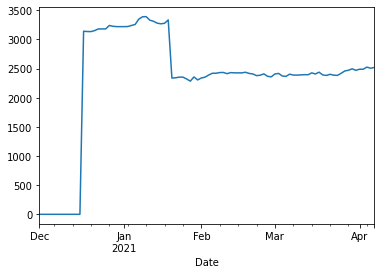

In [96]:
get_patrimony(portfolio).loc['2020-12':].plot()

In [101]:
def get_returns(prices, portfolio):
    
    weights = portfolio.div(portfolio.sum(axis=1), axis=0).fillna(0)
    
    returns = pd.DataFrame(index = weights.index)
    returns['Returns'] = 0

    for time in weights.index:
        returns['Returns'].loc[time] = np.dot(prices.pct_change().loc[time], weights.loc[time])
        
    return returns

<AxesSubplot:xlabel='Date'>

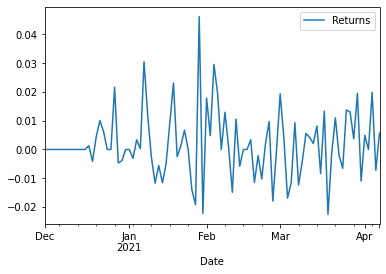

In [102]:
get_returns(prices, portfolio).loc['2020-12':].plot()

In [99]:
def get_cumulative_returns(prices, portfolio):
    
    returns = get_returns(prices, portfolio)
                          
    cumulative_returns = (1 + returns).cumprod()
                          
    return cumulative_returns

<AxesSubplot:xlabel='Date'>

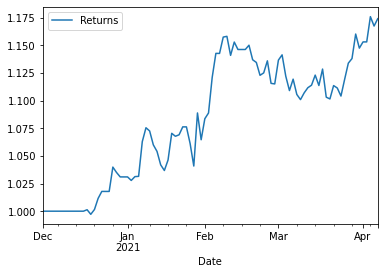

In [100]:
get_cumulative_returns(prices, portfolio).loc['2020-12':].plot()